In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
class Testbed:
    
    def __init__(self, num_arms=10,stationary = True, generate_mean = 0, generate_std = 1, perturb_std = 0.01):
        self.num_arms = num_arms
        self.gen_mean = generate_mean
        self.gen_std = generate_std
        
        self.arms_means = None
        self.greedy_truth = None
        
        self.stationary = stationary
        self.perturb_std = perturb_std
                
    def create_arms_expt(self, experiments = 2000):
        if self.stationary:
            self.arms_means = np.random.normal(self.gen_mean, self.gen_std, [experiments,self.num_arms])
        else:
            self.arms_means = np.ones((experiments,self.num_arms))*np.random.normal(self.gen_mean, self.gen_std, [1])
            
        self.greedy_truth = np.argmax(self.arms_means,axis = 1)
        
    def perturb_distribution(self):
        if not self.stationary:
            self.arms_means = self.arms_means + np.random.normal(self.gen_mean, self.perturb_std, self.arms_means.shape)
            self.greedy_truth = np.argmax(self.arms_means,axis = 1)
        

In [35]:
class Experiments:
    
    def __init__(self,testbed,initialization = 'regular', optimism = 5,epsilons = [0,0.01,0.1], iters = 1000, experiments = 2000):
        self.testbed = testbed
        self.epsilons = epsilons
        self.iters = iters
        self.expts = experiments
        self.initialization = initialization
        self.optimism = optimism
        self.alpha = 'mean'
        
    def init_expt(self):  
        if self.initialization == 'regular':
            self.q = np.zeros((self.expts,self.testbed.num_arms)) # current estimate
        elif self.initialization == 'optimistic':
            self.q = np.ones((self.expts,self.testbed.num_arms))*self.optimism # current estimate
        
        self.t_predicate = np.zeros((self.expts,self.testbed.num_arms)) # number of times given action chosen
        
        self.testbed.create_arms_expt(self.expts)
        
        self.optimal_frac = np.zeros(self.iters)
        self.avg_reward = np.zeros(self.iters)
        
    def set_rand_choice(self,eps):
        self.rand_choice = np.random.choice([0,1],self.expts,p=[eps,1-eps])
            
    def run(self,epsilon,const = 0.1):  
                
        actions = np.zeros((self.expts,2),dtype = 'int32')
        actions[:,0] = np.arange(self.expts)
        
        for iter in range(self.iters):
            self.set_rand_choice(epsilon)
            
            actions[:,1] = self.rand_choice*np.argmax(self.q,axis = 1) + (1-self.rand_choice)*np.random.choice(self.testbed.num_arms,self.expts)
            
            rewards = np.random.normal(self.testbed.arms_means[actions[:,0],actions[:,1]], self.testbed.gen_std, [self.expts])
            
            self.optimal_frac[iter] = float(np.sum(actions[:,1]==self.testbed.greedy_truth))/actions.shape[0]
            self.avg_reward[iter] = float(np.sum(rewards))/rewards.shape[0]
            
            self.t_predicate[actions[:,0],actions[:,1]] += 1.
            
            if self.alpha == 'mean':
                self.q[actions[:,0],actions[:,1]] = self.q[actions[:,0],actions[:,1]] + (rewards - self.q[actions[:,0],actions[:,1]])/self.t_predicate[actions[:,0],actions[:,1]]
            elif self.alpha == 'const':
                self.q[actions[:,0],actions[:,1]] = self.q[actions[:,0],actions[:,1]] + (rewards - self.q[actions[:,0],actions[:,1]])*const
            
            if not self.testbed.stationary:
                self.testbed.perturb_distribution()
            

In [36]:
def run_expt1(): # Varying epsilon , stationary environment
        
        testbed = Testbed()
        e = Experiments(testbed)
        e.alpha = 'mean'
        
        fig1 = plt.figure()
        fig2 = plt.figure()
        fig1.suptitle('Average Reward vs Iterations')
        fig2.suptitle('% Optimal Action vs Iterations')
        ax1 = fig1.add_subplot(111)
        ax2 = fig2.add_subplot(111)
        ax1.set_xlabel("Iterations")
        ax2.set_xlabel("Iterations")
        ax1.set_ylabel("Average Reward")
        ax2.set_ylabel("% Optimal Action")
        
        for eps in e.epsilons:
            e.init_expt()
            e.run(eps)
            ax1.plot(e.avg_reward,label="ε = "+str(eps))
            ax2.plot(e.optimal_frac*100,label="ε = "+str(eps))
            
        ax1.legend(loc='lower right')
        ax2.legend(loc='lower right')
        
        fig1.savefig('avg_reward.png', bbox_inches='tight')
        fig2.savefig('optimal_frac.png', bbox_inches='tight')
        
        fig3 = plt.figure()
        fig3.suptitle('Greedy Ground Truth Distribution (ε = 0.1)')
        ax3 = fig3.add_subplot(111)
        ax3.set_xlabel("Actions")
        ax3.set_ylabel("Frequencies")
        ax3.hist(e.testbed.greedy_truth, bins=10)
        fig3.savefig('ground_truth.png', bbox_inches='tight')
        
        plt.show()

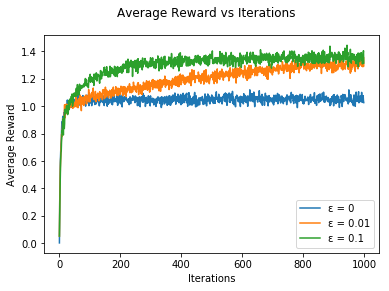

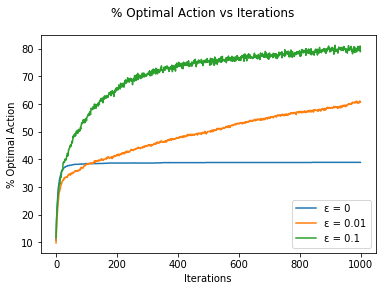

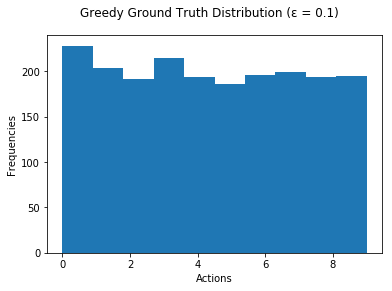

In [37]:
run_expt1()

In [38]:
def run_expt2(const): # Optimistic Initialization
    
        testbed = Testbed()
        e = Experiments(testbed)
        
        e.alpha = 'const'
        
        fig = plt.figure()
        fig.suptitle('% Optimal Action vs Iterations (Varied Initializations)')
        ax = fig.add_subplot(111)
        
        eps = 0 # greedy
        e.initialization = 'optimistic'
        
        e.init_expt()
        e.run(eps)
        ax.plot(e.optimal_frac*100,label="Optimistic,Greedy | Q1 = 5,ε = 0")
        
        eps = 0.1 # ε - greedy
        e.initialization = 'regular'
        
        e.init_expt()
        e.run(eps, const = 0.1)
        ax.plot(e.optimal_frac*100,label="Realistic,ε-Greedy | Q1 = 0,ε = 0.1")
        
        ax.legend(loc='lower right')
        fig.savefig('optimal_frac_optimistic_init.png', bbox_inches='tight')
        plt.show()

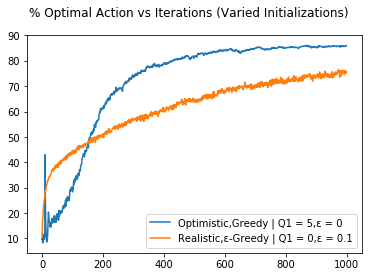

In [39]:
run_expt2(const = 0.1)

In [40]:
def run_expt3(alpha): # Not stationary setting with mean and const step size
    testbed = Testbed(stationary = False)
    e = Experiments(testbed,iters = 10000)
    
    fig1 = plt.figure()
    fig2 = plt.figure()
    fig1.suptitle('Average Reward vs Iterations (Non stationary setting , α = '+alpha+')')
    fig2.suptitle('% Optimal Action vs Iterations (Non stationary setting , α = '+alpha+')')
    ax1 = fig1.add_subplot(111)
    ax2 = fig2.add_subplot(111)
    ax1.set_xlabel("Iterations")
    ax2.set_xlabel("Iterations")
    ax1.set_ylabel("Average Reward")
    ax2.set_ylabel("% Optimal Action")
    
    e.alpha = alpha
    eps = 0.1 
    e.initialization = 'regular'
    e.init_expt()
    e.run(eps)
    
    ax1.plot(e.avg_reward,label="ε = "+str(eps))
    ax2.plot(e.optimal_frac*100,label="ε = "+str(eps))
                    
    fig1.savefig('avg_reward_no_stationary_'+alpha+'.png', bbox_inches='tight')
    fig2.savefig('optimal_frac_no_stationary_'+alpha+'.png', bbox_inches='tight')
    
    plt.show()

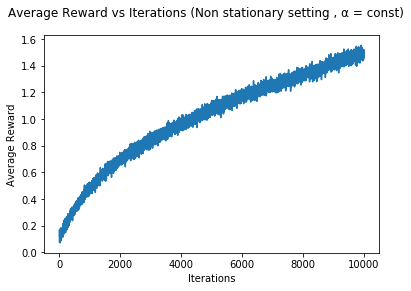

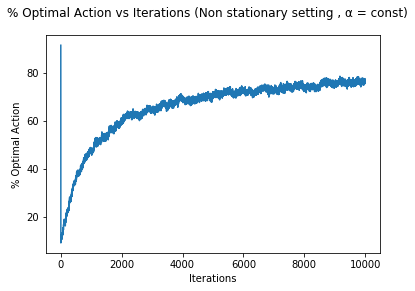

In [41]:
run_expt3(alpha ='const')

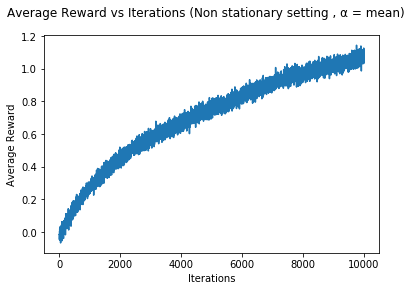

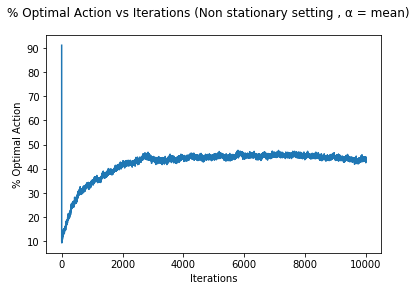

In [42]:
run_expt3(alpha = 'mean')

In [43]:
def run_expt4(const): # Optimistic Initialization in non stationary environment
    
        testbed = Testbed(stationary = False)
        e = Experiments(testbed,iters = 1000)
        
        e.alpha = 'mean'
        
        fig = plt.figure()
        fig.suptitle('% Optimal Action vs Iterations (Optimistic Initializations - Non Stationary - constant alpha)')
        ax = fig.add_subplot(111)
        
        eps = 0 # greedy
        e.initialization = 'optimistic'
        
        e.init_expt()
        e.run(eps)
        ax.plot(e.optimal_frac*100,label="Optimistic,Greedy | Q1 = 5,ε = 0")
        
        eps = 0.1 # ε - greedy
        e.initialization = 'regular'
        
        e.init_expt()
        e.run(eps, const = 0.1)
        ax.plot(e.optimal_frac*100,label="Realistic,ε-Greedy | Q1 = 0,ε = 0.1")
        
        ax.legend(loc='lower right')
        fig.savefig('optimal_frac_optimistic_init_non_stationary.png', bbox_inches='tight')
        plt.show()

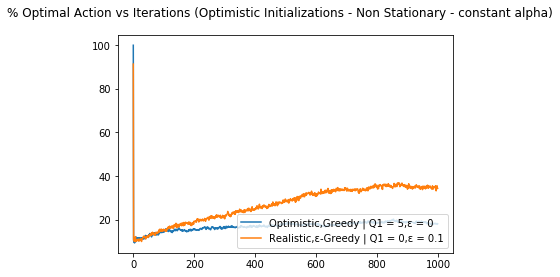

In [44]:
run_expt4(const = 0.1) 